# Introduction


### It must be stressed that the ideas contained in this notebook have not gone through rigorous testing and validation. This work was done in a couple of hours. I will not trade it as it is and I do not advise the reader to do so either. This was actually a a proposal for more rigorous work that was done eventually. The actually work is split in many notebooks and adheres to a more rigorous process. This is just an enjoyable read. Thus, a lot of statistical exploration, testing, and optimization has been ommitted. There has been some overfitting and bias implicit in the development process both by the algorithms and by me. This is for convenience sake. The infromation in this notebook does not serve as investment advice but as an exploration of a possibility. Enjoy!


In this notebook, I analyse the time series properties of the Litecoin crypto-currency and then proceed to building a predictive model based on my discoveries. I test the efficacy of the model with a naive trading strategy. I then proceed to improve on this model by adding additional the returns of other crypto-currencies to build a classification based predictive model. I then test this improved model with a similar naive strategy

Why Litecoin? Random. And I like the name

This notebook is largely of my own creation but consists of code from: 

QuantAtRisk:
(http://www.quantatrisk.com/2017/03/31/cryptocurrency-portfolio-correlation-pca-python/) for web scraping crypto-currency data,

Quantopian Lecture Series:
(https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Autocorrelation%20and%20AR%20Models%22.ipynb) for parts of the ACF and PACF correlogram

Machine Learning Mastery:
(https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) for some parts of the AR & MA model implementations.


There will be an accompanying cheat-sheet explaining most of the concepts introduced here soo it can be understood at some level by most readers


## Retrieving Crypto-Currency data 
In this codeblock pricing data for 21 crypto currencies (including litecoin) are retrieved from cryptocompare using the BeautifulSoup web scraping module.



In [28]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import json
from bs4 import BeautifulSoup
import requests
 
# define some custom colours
grey = .6, .6, .6
 
useless = 1  #ignore this
def timestamp2date(timestamp):
    # function converts a Unix timestamp into Gregorian date
    return datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d')
 
def date2timestamp(date):
    # function coverts Gregorian date in a given format to timestamp
    return datetime.strptime(date_today, '%Y-%m-%d').timestamp()
 
def fetchCryptoClose(fsym, tsym):
    # function fetches the close-price time-series from cryptocompare.com
    # it may ignore USDT coin (due to near-zero pricing)
    # daily sampled
    cols = ['date', 'timestamp', fsym]
    lst = ['time', 'open', 'high', 'low', 'close']
    timestamp_today = datetime.today().timestamp()
    curr_timestamp = timestamp_today
 
    for j in range(2):
        df = pd.DataFrame(columns=cols)
        url = "https://min-api.cryptocompare.com/data/histoday?fsym=" + fsym + \
              "&tsym=" + tsym + "&toTs=" + str(int(curr_timestamp)) + "&limit=2000"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        dic = json.loads(soup.prettify())
        for i in range(1, 2001):
            tmp = []
            for e in enumerate(lst):
                x = e[0]
                y = dic['Data'][i][e[1]]
                if(x == 0):
                    tmp.append(str(timestamp2date(y)))
                tmp.append(y)
            if(np.sum(tmp[-4::]) > 0):  # remove for USDT
                tmp = np.array(tmp)
                tmp = tmp[[0,1,4]]  # filter solely for close prices
                df.loc[len(df)] = np.array(tmp)
        # ensure a correct date format
        df.index = pd.to_datetime(df.date, format="%Y-%m-%d")
        df.drop('date', axis=1, inplace=True)
        curr_timestamp = int(df.iloc[0][0])
        if(j == 0):
            df0 = df.copy()
        else:
            data = pd.concat([df, df0], axis=0)
    data.drop("timestamp", axis=1, inplace=True)
 
    return data  # DataFrame

This code block stores the retrieved data in a HDF5 file and then reads it into a pandas dataframe.

In [29]:
# N-Cryptocurrency Portfolio (tickers)
fsym = ['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'LTC', 'ETC', 'XEM', 'REP', 
        'MAID', 'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 'DGD', 
        'WAVES', 'DCR', 'LSK', 'DOGE', 'PIVX']
# vs. 
tsym = 'USD'

for e in enumerate(fsym):
    print(e[0], e[1])
    if(e[0] == 0):
        try:
            data = fetchCryptoClose(e[1], tsym)
        except:
            pass
    else:
        try:
            data = data.join(fetchCryptoClose(e[1], tsym))
        except:
            pass
 
useless = 1 #ignore this
data = data.astype(float)  # ensure values to be floats
 
# save portfolio to a file (HDF5 file format)
store = pd.HDFStore('portfolio.h5')
store['data'] = data
store.close()
 
# read in your portfolio from a file
df = pd.read_hdf('portfolio.h5', 'data')
#print(df)

0 BTC
1 ETH
2 DASH
3 XMR
4 XRP
5 LTC
6 ETC
7 XEM
8 REP
9 MAID
10 ZEC
11 STEEM
12 GNT
13 FCT
14 ICN
15 DGD
16 WAVES
17 DCR
18 LSK
19 DOGE
20 PIVX


In this code block, the dataframe containing crypt currency pricing data is purged of all NaN values to prevent excessive data cleaning and filling of missing data. This is a trade-off between sample size and accuracy. It is also less stressful.

In [30]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from pandas import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

df2 = df.dropna()["2017-10-16":"2018-08-18"] #I set the dates so that the results remain the same unless changed
X = df2['LTC']#resample('W').last().dropna()
X.shape


(307,)

##  ACF and PACF


This code block is used to calculate the autocorrelation and partial autocorrelation coefficients for lag periods from 1 to 20. These will be used to determine if the time series follows an Autoregressive (AR) or a Moving Average (MA) process.

In [31]:
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 20
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].
X_acf = acf(X, nlags=nlags)
print('Autocorrelations:\n' + str(X_acf) + '\n')
X_pacf = pacf(X, nlags=nlags)
print('Partial Autocorrelations:\n' + str(X_pacf))

Autocorrelations:
[ 1.          0.96498192  0.93720143  0.90538371  0.88073569  0.85299546
  0.82668444  0.7959813   0.76338036  0.72737277  0.70086988  0.67724932
  0.64952355  0.62347578  0.59922577  0.57665525  0.55242586  0.5318352
  0.50409244  0.48207371  0.46165673]

Partial Autocorrelations:
[ 1.          0.96813546  0.0966415  -0.0687265   0.08603894 -0.0399139
 -0.0121622  -0.0717944  -0.07272546 -0.07783142  0.11720232  0.06317415
 -0.09834853  0.02428793  0.03669857  0.0070555  -0.04619125  0.02386702
 -0.14368555  0.06591639  0.07796237]


## Correlograms

Now that the autocorrelation coefficients have been discovered. Correlograms can be plotted to present the findings graphically.
Confidence intervals have also been plotted to prevent statistically insignificant autocorrelations from being perceived as relevant

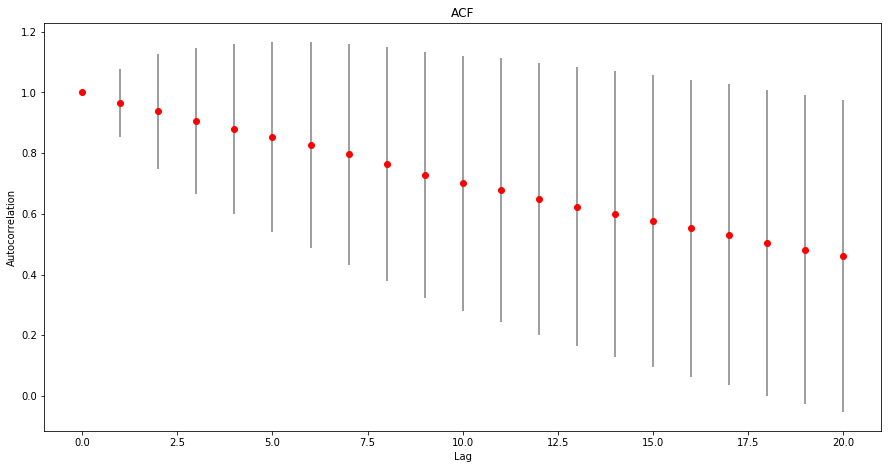

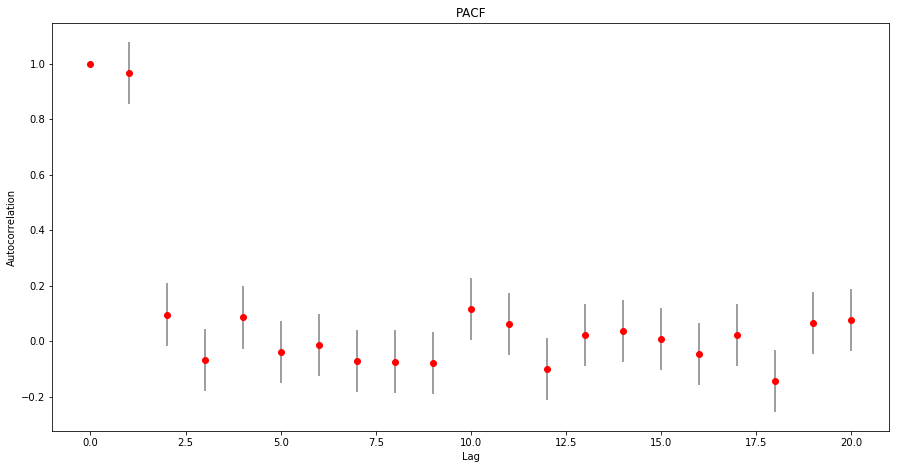

In [32]:
def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
    
# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)
#plot_acf(X_acf, X_acf_confs)
plt.figure(figsize = (15,7.5))
plot_acf(X_acf, X_acf_confs, title='ACF')
plt.figure(figsize = (15,7.5))
plot_acf(X_pacf, X_pacf_confs, title='PACF')

# Testing the AR Hypothesis

From the graphs above it is clear that the Autocorrelation function is declines geometricallly with increase in lag.
The Partial Autocorrelation function ins significant only for the first two lags.
This indicates that the time series is strongly inclined towrds an Autoregressive model rather than a Moving avarage. 
It also indicates that the order of the Autoregrssive model is 2. 

An autoregressive model and a Moving Average model are then built to test this hypothesis. If it is correct the autoregressive model will have less mean squared error.


In [33]:
#train-test split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

#rolling predictions_AR
history = [x for x in train]
predictions_AR = list()
for t in range(len(test)):
    model = ARIMA(history, order = (2,0,0))
    model_fit_AR = model.fit(disp = False)
    output = model_fit_AR.forecast()
    yhat = output[0]
    predictions_AR.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
#accuracy testing
error = mean_squared_error(test, predictions_AR)
print('Test MSE: %.3f' % error)

Test MSE: 19.697


In [34]:
#train-test split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

#rolling predictions_MA
history = [x for x in train]
predictions_MA = list()
for t in range(len(test)):
    model = ARIMA(history, order = (0,0,2))
    model_fit_MA = model.fit(disp = False)
    output = model_fit_MA.forecast()
    yhat = output[0]
    predictions_MA.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
#accuracy testing
error = mean_squared_error(test, predictions_MA)
print('Test MSE: %.3f' % error)

Test MSE: 353.470


The mean squared error of the AR model is 19.582 while that of the MA model is 348.206. This difference is significant. 
Thus, it confirms that for the sample being observed, the underlying time series process is more inclined towards an
Autoregressive process than a Moving Average Process. 
 
The code block below show a statistical analysis of the results of fitting bothe models to the time series data

In [35]:
print(model_fit_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  306
Model:                     ARMA(2, 0)   Log Likelihood               -1259.745
Method:                       css-mle   S.D. of innovations             14.779
Date:                Fri, 02 Aug 2019   AIC                           2527.491
Time:                        13:50:52   BIC                           2542.385
Sample:                             0   HQIC                          2533.447
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.3654     29.025      3.940      0.000      57.478     171.253
ar.L1.y        0.8647      0.057     15.260      0.000       0.754       0.976
ar.L2.y        0.1089      0.057      1.914      0.0

In [36]:
print(model_fit_MA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  306
Model:                     ARMA(0, 2)   Log Likelihood               -1438.365
Method:                       css-mle   S.D. of innovations             26.541
Date:                Fri, 02 Aug 2019   AIC                           2884.729
Time:                        13:50:53   BIC                           2899.623
Sample:                             0   HQIC                          2890.686
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.9083      4.222     30.535      0.000     120.634     137.183
ma.L1.y        1.1204      0.050     22.340      0.000       1.022       1.219
ma.L2.y        0.6701      0.033     20.595      0.0

A plot illustrates the difference in accuracy between the AR model and the MA model. The AR model's prediction closely
follows the results from the actual data generating process, while the MA process loosely follows it.

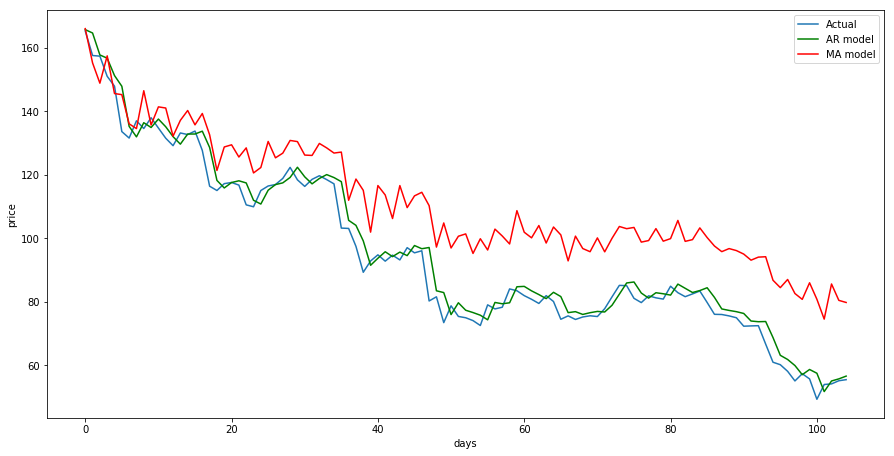

In [37]:
#plot of actual price as well as AR and MA predictions
plt.figure(figsize = (15,7.5))
plt.plot(range(len(test)),test)
plt.plot(range(len(test)),predictions_AR, color='green')
plt.plot(range(len(test)),predictions_MA, color='red')
plt.legend(['Actual', 'AR model', 'MA model'])
plt.ylabel('price')
plt.xlabel('days')

## Simple Implementation as a trading strategy

A simple trading startegy is developed to test the feasibility of this model for trding purposes. The trading 
algorithm simply buys when the current price is below the AR prediction (undervalued) for the next day and sells 
when it is above (overvalued). The algo holds a position for a single day and then re-evaluates for the next day. If the AR prediction and the price are the same, the algorithm does nothing.
Transactions costs, stop loss orders, bet sizing, and other factors have not been considered. 

In [38]:
# the trade
profit = np.zeros(len(test)-1)
for i in range(1,len(test)):
    if predictions_AR[i] > test[i-1]:
        profit[i-1] = 1 * (test[i]-test[i-1])/test[i-1]#go long if predcitions > current
    if predictions_AR[i] < test[i-1]:
        profit[i-1] = -1 * (test[i]-test[i-1])/test[i-1]#go short if predcitions < current
    if predictions_AR[i] == test[i-1]:
        profit[i-1] = 0 #do nothing if predictions  = current

profit;

## Assessment of AR trading strategy

A plot is made to visualize the returns from trading this strategy. Although it outperforms a buy and hold strategy, the trading algorithm loses money (despite the predictive power of the AR model (low mean squared error)). I hypothesize that this is because a good prediction only infers one that is close to the actual value and does not matter whether it is greater than or less than this value. This matters in the trading strategy.

In this case, although predictions are close to the actual value, they repeatedly miss the mark in terms of direction. For exmaple,let's say the current price of LTC is 10. Model A's (random name) prediction of tomorrow's price is 11, while model B's prediction is 4. If the tomorrow's price ends up being 9, model A's squared error will be 2 x 2 = 4, while model B's will be 5 x 5 = 25. Clearly, model A is a better predictor of price. 
But a trading algorithm that works by taking a position based on the relative price will have gone long based on model A's prediction, and short based on model B's prediction. Algo A will have lost 2 (11 - 9 = 2) on the trade while ALgo B will have made 1 (10 - 9 = 1) on the trade. Thus Algo B has the upper hand in such a trade.

In this case, my hypothesis that the AR model often misses the direction of the next day's move even though it comes very close to the actual price can be tested by calculating the corrrelation coefficient between the actual change in price and the change in price predicted by the AR model. This is done below:

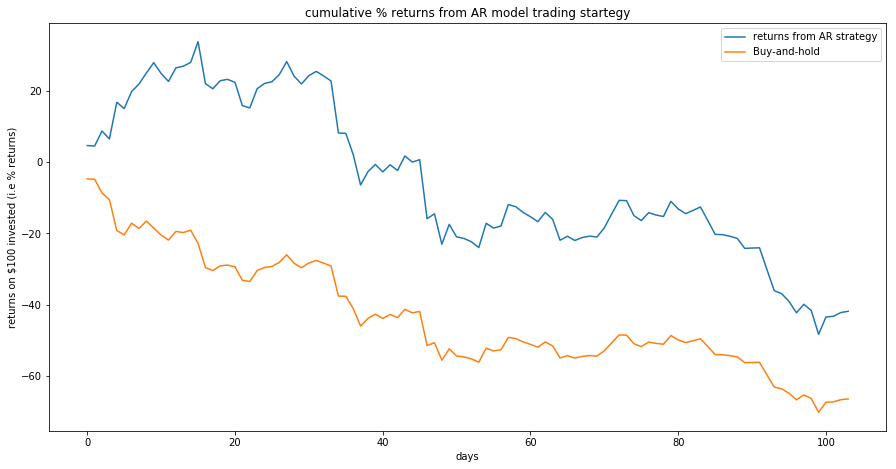

In [39]:
# plot of AR, MA, Buy and Hold returns
plt.figure(figsize = (15,7.5))
plt.plot(range(len(profit)), (np.cumprod(profit+1)-1)*100)
plt.plot(range(len(profit)),(np.cumprod(X.pct_change().dropna()[size:len(X)]+1)-1)*100)
plt.legend(['returns from AR strategy', 'Buy-and-hold'])
plt.xlabel('days')
plt.ylabel('returns on $100 invested (i.e % returns)')
plt.title('cumulative % returns from AR model trading startegy')

In [40]:
#a bit of data processing - adjusting dimensions so a correlation martix can be derived
if str(type(predictions_AR[1])) == "<class 'numpy.ndarray'>":
    len(predictions_AR)
    len(test)
    np.array(predictions_AR)
    for i in range(len(predictions_AR)):
        predictions_AR[i] = predictions_AR[i][0]

    predictions_AR = list(predictions_AR)
    len(predictions_AR)
    
#calculation of the correlation cof between the predictions and actual
predicted_change= predictions_AR[1:] - test[:-1]
predicted_change = predicted_change[:]
predicted_change = np.array(predicted_change)
print(predicted_change.shape)

actual_change = np.array(test[1:]) - np.array(test[:-1])
actual_change = actual_change[:]
actual_change = np.array(actual_change)
print(actual_change.shape)

np.corrcoef(predicted_change,actual_change)

(104,)
(104,)


array([[ 1.        ,  0.22301978],
       [ 0.22301978,  1.        ]])



The correlation co-efficient of the predicted change and the actual change is merely 0.22. This means that it is weakly 
correlated and thus explains the poor performance of the trading strategy.

# Alternative Models - Linear Classifiers

In this section I aim to develop an alternative model to outperform the AR model by utilising hsitorical pricing data from other cryptocurrencies as well as LTC. 20 additional crypto-currencies have been added to the fold for this purpose. Their prices will be backdated by a single day to avoid look-ahead bias. LTC past pricing data is also utilised as a feature. For each crypto-currency, only the previous day's pricing data is used to predict the current day's price of LTC. 

Two linear classifiers are used to test this: A logistic regression classifier and a Support Vector Classifier. 
Classifiers are used as opposed to numerical regression because classifiers can be better trained to predict the direction
of change in price. Since the trading strategy does not have a target 'take profit price', there is no advantage to getting a numerical figure for the predicted change in price.

In this code block, the pricing data of the predictors (features) is backdated by a day to avoid look-ahead bias.
The target variable is discretised to {-1,0,1} corresponding to {decrease, none, increase} movement in price.



In [41]:
features = df2 [['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'ETC','LTC', 'XEM', 'REP', 
        'MAID', 'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 'DGD', 
        'WAVES', 'DCR', 'LSK', 'DOGE', 'PIVX']].pct_change().dropna()[:-1]#backdate

#with screening for high correlation
"""features = df2 [['BTC', 'ETH', 'DASH', 'XMR', 'XRP', 'ETC','LTC', 'XEM', 'REP', 
        'MAID', 'ZEC', 'STEEM', 'GNT', 'FCT', 'ICN', 
        'WAVES', 'LSK', 'DOGE', 'PIVX']].pct_change().dropna()[:-1]"""

LTC = df2['LTC'].pct_change()[1:].dropna()[1:]#forward date
target = [1  if i > 0 else -1 for i in LTC]
features.shape

(305, 21)

## Logistic Regression

The data is trained and tested on with a Linear Regression model
This gives a 52.43 percent accuracy. This is marginally better than random and very likely to be statistically insignificantly
different from random. The confusion matrix shows that it predicts 


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

model_LR = LogisticRegression()
model_LR.fit(train_f, train_t)
predictions = model_LR.predict(test_f)
predictions = list(predictions)
#print(predictions)
#print(test_t)


conf = confusion_matrix(test_t, predictions)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))

the confusion matrix: 
 [[19 43]
 [ 6 35]]

the proportion of correct predictions: 52.4272 percent


## Support Vector Classifier

The data is trained and tested on with a Suppor Vector Classifier model
This gives a 40.77 percent accuracy. This is marginally worse than random and very likely to be statistically insignificantly
different from random. The confusion matrix shows that it predicts all returns to be positive (There is a name for 
this kind of trivial behaviour by a classifier but I cant remember right now). This is probably due to a predominance of 
positive returns in the training data.


In [43]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

model_SVC = SVC()
model_SVC.fit(train_f, train_t)
predictions_SVC = model_SVC.predict(test_f)
predictions_SVC = list(predictions_SVC)
#print(predictions_SVC)
#print(test_t)

conf = confusion_matrix(test_t, predictions_SVC)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))

the confusion matrix: 
 [[ 0 62]
 [ 0 41]]

the proportion of correct predictions: 39.8058 percent


## Decision Tree Classifier

The same is done with a decision tree.

In [44]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

model_DTC = DTC()
model_DTC.fit(train_f, train_t)
predictions_DTC = model_DTC.predict(test_f)
predictions_DTC = list(predictions_DTC)
#print(predictions_DTC)
#print(test_t)

conf = confusion_matrix(test_t, predictions_DTC)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))

the confusion matrix: 
 [[38 24]
 [21 20]]

the proportion of correct predictions: 56.3107 percent


The correlation properties of the features are examined via a heatmap and shown below. This could be used to better select features or motivate PCA reduction. Features with low correlation with the target can be removed as they are most likey less predictive.

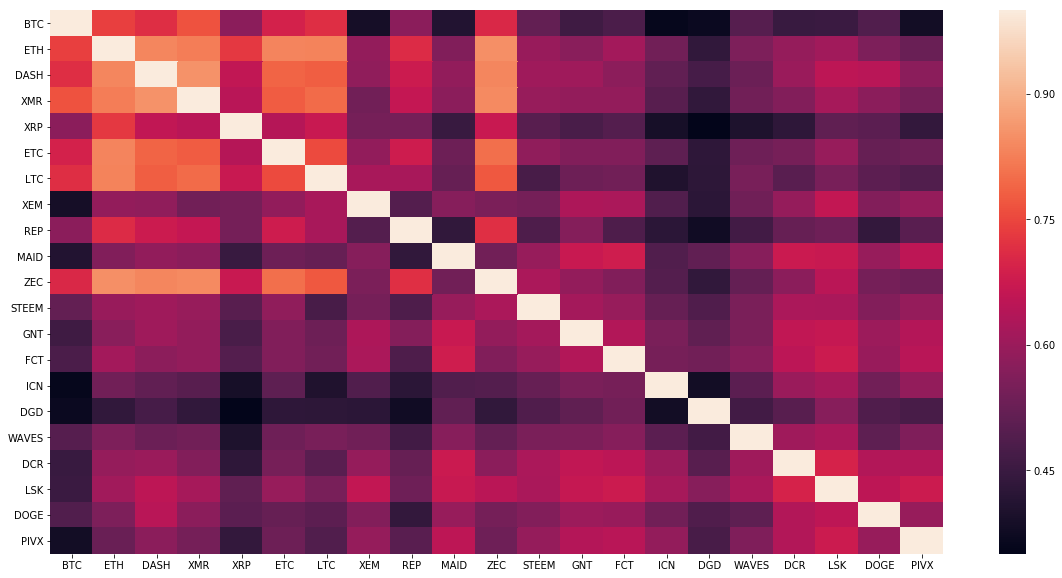

In [45]:
# plot the heatmap

import seaborn as sns
plt.figure(figsize= (20,10))
corr = features.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## PCA


In order to improve on the model, PCA and whitening (sphering) is carried out on the features. This reduces the 
dimensionality of the data and also reduces the correlation of the features with eachother. Thus, it prevents unwanted properties such a multicollinearity and also improves the observations to features ratio. This makes it easier for the ML algo to come up with a model that is realistic. A simple way to think of this is that it combines correlated features in order to produce a single one that accounts for them. In essence, I have reduced the dimensionality of the features from 21 to 5 while retainig most of the information available in the 21 and also making the model less prone to errors caused by having redundant features.


Note: The choice of 5 components is via a heuristic I call 'lazy manual local search' (i.e. fancy name for 'Trial and Error'. It also helps to balance the ratio of observations to features from about 15 to about 60. Not scientific/professional at all). An optimized choice could be settled on after  some sort of convex optimization algo, brute force search, or visually.

## Whitened PCA Logistic Regression
The application of PCA reduction prior to applying a Logistic Regression Classifier has significantly improved its performance.Now it has an accuracy rate of 67 percent and a more balanced confusion matrix (indicating less bias towards aparticular class in the model's decisions)


##### Note: There is little doubt that this models have been overfit to the data. Much more scrutiny is needed to develop a model that is robust to datasets.

In [46]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.pipeline

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

pipe = Pipeline([('pca', PCA(n_components=5, whiten=True)),
                      ('LR',LogisticRegression())])

pipe.fit(train_f, train_t)
predictions_pipe_LR = pipe.predict(test_f)
conf = confusion_matrix(test_t, predictions_pipe_LR)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))

the confusion matrix: 
 [[38 24]
 [ 8 33]]

the proportion of correct predictions: 68.9320 percent


## Whitened PCA Support Vector Classifier

Similar to the results of the PCA-LogisticRegresion model, the application of PCA reduction prior to applying a Support Vector Classifier has significantly improved its performance.Now it has an accuracy rate of 75 percent and a much more balanced confusion matrix (eliminating the bias towards the positve class notice previously)

##### Note: There is little doubt that this models have been overfit to the data. Much more scrutiny is needed to develop a model that is robust to datasets.

In [47]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.pipeline

size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

pipe = Pipeline([('pca', PCA(n_components=5, whiten=True)),
                      ('SVC',SVC())])

pipe.fit(train_f, train_t)
predictions_pipe_SVC = pipe.predict(test_f)
conf = confusion_matrix(test_t, predictions_pipe_SVC)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))


the confusion matrix: 
 [[54  8]
 [13 28]]

the proportion of correct predictions: 79.6117 percent


## Whitened PCA Decision Tree

The same is done for the decison tree classifier and yields a hit rate of about 60% (varies between 55 and 65 with each iteration)

In [48]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import sklearn.pipeline


size = int(len(X) * 0.66)
train_f, test_f = features[0:size], features[size:len(X)]
train_t, test_t = target[0:size], target[size:len(X)]

pipe = Pipeline([('pca', PCA(n_components=5, whiten=True)),
                      ('DTC',DTC())])

pipe.fit(train_f, train_t)
predictions_pipe_DTC = pipe.predict(test_f)
conf = confusion_matrix(test_t, predictions_pipe_DTC)
conf_sum = np.sum(np.sum(conf, axis= 1))
hit_rate = (conf[0,0] + conf[1,1])/ conf_sum # % of correct predictions

print('the confusion matrix: \n {}' .format(conf))
print('\nthe proportion of correct predictions: %.4f percent'%(hit_rate * 100))


the confusion matrix: 
 [[36 26]
 [13 28]]

the proportion of correct predictions: 62.1359 percent


## Implementations as trading strategy

he same traidng strategy is constructed for the W-PCA-LR, W-PCA-SVC, W-PCA-DTC models (W- for whitening) as used with the AR model. The only difference is that this is coded up in a vecotrised manner as it was most convenient since the classes {-1, 0, 1} also represent the next day decision {sell, none, buy}. 

The returns of bothe strategies are plotted below.

Note: The AR trading stategy could have been coded in a vectrised manner but wasn't for transparency sake.

In [49]:
profit_LR = predictions_pipe_LR * LTC[size:len(X)]
profit_SVC = predictions_pipe_SVC * LTC[size:len(X)]
profit_DTC = predictions_pipe_DTC * LTC[size:len(X)]

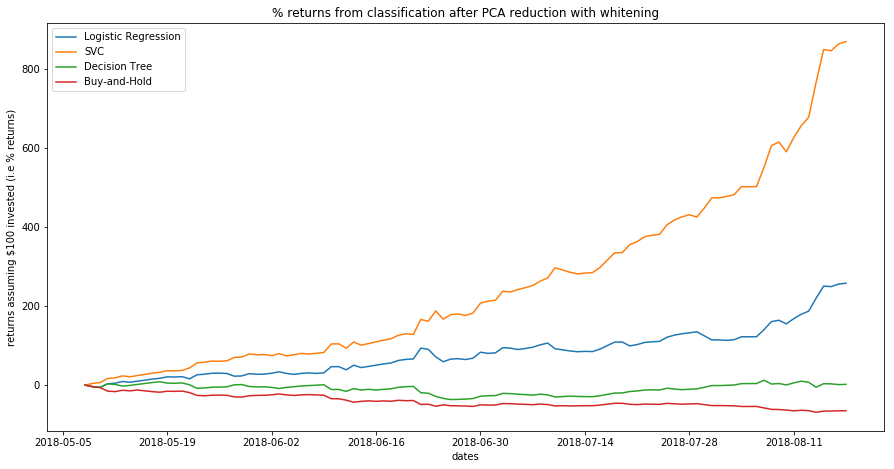

In [50]:
plt.figure(figsize = (15,7.5))
plt.plot((np.cumprod(profit_LR+1)-1)*100)
plt.plot((np.cumprod(profit_SVC+1)-1)*100)
plt.plot((np.cumprod(profit_DTC+1)-1)*100)
plt.plot((np.cumprod(LTC[size:len(X)]+1)-1)*100)
plt.legend(['Logistic Regression', 'SVC', 'Decision Tree', 'Buy-and-Hold'])
plt.title('% returns from classification after PCA reduction with whitening')
plt.xlabel('dates')
plt.ylabel('returns assuming $100 invested (i.e % returns)')



The results show that both strategies are profitable but do not give the exact same trades. Some summary performance statistics of the strategies have been computed below. 

##### NOTE: The VaR are probably inaccurate as the distributuons are not normal as shown in the poor fit to the normal distribution.

##### CAUTION: Excessively high sharpe ratios of 3 and above typically do not occur on trading strategies that utilise a daily trading frequency. This result indicates that the model is most likely overfit to the test as well as the training data

the expected daily return is: 1.3268 percent
the standard deviation measured daily is: 4.1242 percent
the 95-pct confidence daily Value-at-Risk is: -6.9216 percent
the sharpe ratio (assuming 0 benchmark returns) is: 5.1070


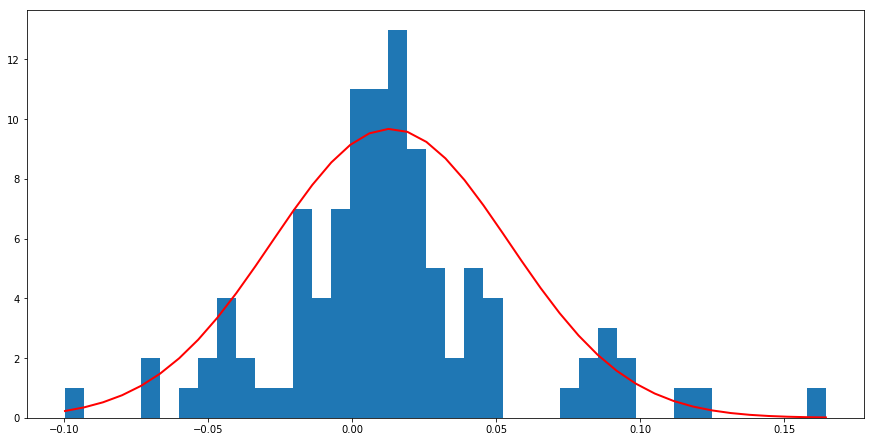

In [51]:
plt.figure(figsize = (15,7.5))
count, bins,_= plt.hist(profit_LR, bins = 40)
mu = profit_LR .mean(axis = 0)
sigma = profit_LR.std(axis = 0)

var95 = (mu - 2* sigma)
#print(type(mu))

print('the expected daily return is: %.4f percent'%(mu*100))
print('the standard deviation measured daily is: %.4f percent'%(sigma*100))
print('the 95-pct confidence daily Value-at-Risk is: %.4f percent'%(var95*100))
print('the sharpe ratio (assuming 0 benchmark returns) is: %.4f'%(np.sqrt(252)*mu/sigma))

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')


the expected daily return is: 2.2927 percent
the standard deviation measured daily is: 3.6714 percent
the 95-pct confidence daily Value-at-Risk is: -5.0500 percent
the sharpe ratio (assuming 0 benchmark returns) is: 9.9133


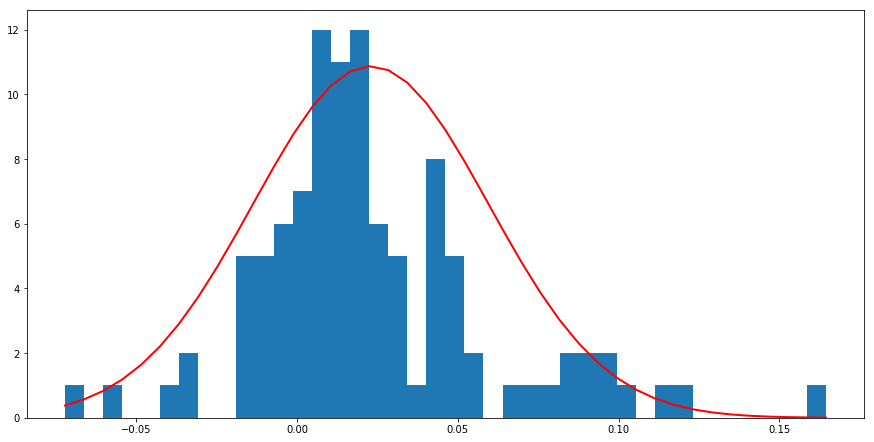

In [52]:
plt.figure(figsize = (15,7.5))
count, bins,_= plt.hist(profit_SVC, bins = 40)
mu = profit_SVC .mean(axis = 0)
sigma = profit_SVC.std(axis = 0)

var95 = (mu - 2* sigma)
#print(type(mu))

print('the expected daily return is: %.4f percent'%(mu*100))
print('the standard deviation measured daily is: %.4f percent'%(sigma*100))
print('the 95-pct confidence daily Value-at-Risk is: %.4f percent'%(var95*100))
print('the sharpe ratio (assuming 0 benchmark returns) is: %.4f'%(np.sqrt(252)*mu/sigma))

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')

the expected daily return is: 0.1136 percent
the standard deviation measured daily is: 4.3329 percent
the 95-pct confidence daily Value-at-Risk is: -8.5522 percent
the sharpe ratio (assuming 0 benchmark returns) is: 0.4161


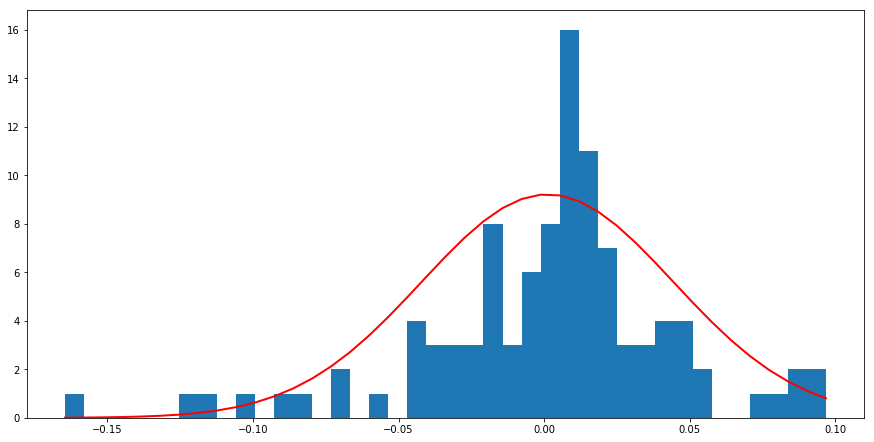

In [53]:
plt.figure(figsize = (15,7.5))
count, bins,_= plt.hist(profit_DTC, bins = 40)
mu = profit_DTC .mean(axis = 0)
sigma = profit_DTC.std(axis = 0)

var95 = (mu - 2* sigma)
#print(type(mu))

print('the expected daily return is: %.4f percent'%(mu*100))
print('the standard deviation measured daily is: %.4f percent'%(sigma*100))
print('the 95-pct confidence daily Value-at-Risk is: %.4f percent'%(var95*100))
print('the sharpe ratio (assuming 0 benchmark returns) is: %.4f'%(np.sqrt(252)*mu/sigma))

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')

# Conclusion
This has been a very surface level exploration of the application of Time Series as well as Machine Learning Analytics to predicting the price/returns of crypto currencies. The biggest limitation in this analysis is the small sample size of just about 300 days. This left 200 for trainig set data and 100 for test set data. This is not even close to enough for 21 features. Thus the resulting models are likely to not be robust

I sincerely doubt that an in-sample sharpe ratio of 4 or 6 on strategy that trades daily will hold out of sample but this I hope this will have encouraged the reader to perform more interesting analysis of their own. Additional tests must be carried out to ensure the robustness of the models and the efficacy of the trading strategy. Below are some of the many suggestions that can be used to extend this analysis.




# Suggestions for improvement
0. Get someone to independently check for reproducibility
1. Test predictive power on larger sample space
2. Use bagging to make up for small sample space and reduce over fitting
3. Try more classifiers e.g random forests, etc
4. Try VAR and VEC time series models on a basket of crypto currencies
5. Remove young crypto-currencies so as to enlarge the sample space for more robust testing
6. Try more diverse trading strategies e.g longer holding period, stop loss, take profit, etc
7. Include considerations of (6) in training the ML model and not just in implementing the trading strategy
8. Meta-Strategy Ensemble: Use one ML model to predict when trading strategy will be accurate or not
9. Include sentiment data e.g twitter, news, etc for target coin
10. Consider bet sizing by probabilities derived by classifiers
11. Include transactions cost
12. Correlation Screening
13. Test each feature independently before including in the model
13. Many more than I am willing to type in. Use your creativity. But use it with caution
